# Deep Hedging [Finance & Machine Learning 2021/22]

## Authors: Jonathan Baker, Juraj Zelman

In [17]:
import numpy as np, matplotlib.pyplot as plt

# Import from Classes
from Classes.hestonModelGenerator import hestonGenerator
from Classes.bsModelGenerator import bsGenerator

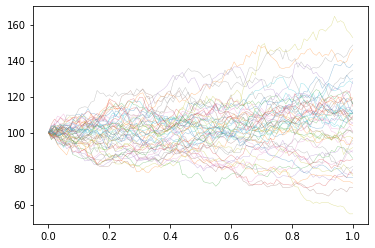

In [18]:
batchSize = 50

for S in bsGenerator(batchSize = batchSize):
    pass
for i in range(batchSize):
    plt.plot(np.linspace(0,1,100+1), S[i,:], alpha = 0.5, linewidth = 0.4)
plt.show()

In [21]:
print(type(bsGenerator(batchSize = batchSize)))
for S in bsGenerator(batchSize = batchSize):
    pass
print(type(hestonGenerator(batchSize)))
for S in hestonGenerator(batchSize = batchSize):
    pass

<class 'Classes.bsModelGenerator.bsGenerator'>
<class 'Classes.hestonModelGenerator.hestonGenerator'>


TypeError: __init__() got an unexpected keyword argument 'batchSize'

In [20]:
batchSize = 50

for S in hestonGenerator(batchSize = batchSize):
    pass
for i in range(batchSize):
    plt.plot(np.linspace(0,1,100 + 1), S[i,:], alpha = 0.5, linewidth = 0.4)
plt.show()

TypeError: __init__() got an unexpected keyword argument 'batchSize'